In [2]:
import os
import numpy as np
import scipy.optimize as so
import matplotlib.pyplot as plt
plt.clf()
plt.close('all')
plt.style.use('classic')
import csv
import ROOT as r
%jsroot on

Welcome to JupyROOT 6.26/02


In [3]:
# FILE TO BE ANALYZED #
date = "20220413/"
fileName = "60Co_CLYC_PD"

In [4]:
def readSpeFile(data_dir, fileName):
    '''
        function to read the files of the type ".Spe" (an analogous ones with the content of each bin instead of just counts)
    '''
    route = data_dir + fileName + ".Spe"
    f = open(route, "r").read()
    data = f.split('\n')

    global bins
    bins = 8192

    bin_content = []
    startlines_toskip = 12
    for j in range(startlines_toskip, bins + startlines_toskip):
        bin_content.append(int(data[j]))
    return np.array(bin_content, "int")

In [5]:
data_dir = "data/" # not to be changed
analysis_dir = "analysis/" # not be changed

# definition of optimal parameters for the spectrum acquired with PD and ML CLYCs
if fileName == "60Co_CLYC_ML":
    xMin = 50; xMax = 900
    xMinfit1 = 660; xMaxfit1 = 725
    xMinfit2 = 745; xMaxfit2 = 820
    p01 = [4000, 700, 40, 0, 0]
    p02 = [4000, 785, 40, 0, 0]
elif fileName == "60Co_CLYC_PD":
    xMin = 250; xMax = 1200
    xMinfit1 = 940; xMaxfit1 = 1040
    xMinfit2 = 1060; xMaxfit2 = 1150
    p01 = [1300, 950, 40, 0, 0]
    p02 = [1300, 1150, 40, 0, 0]

bin_content = readSpeFile(data_dir, date + fileName)
xbins = np.arange(bins)

(250.0, 1200.0)

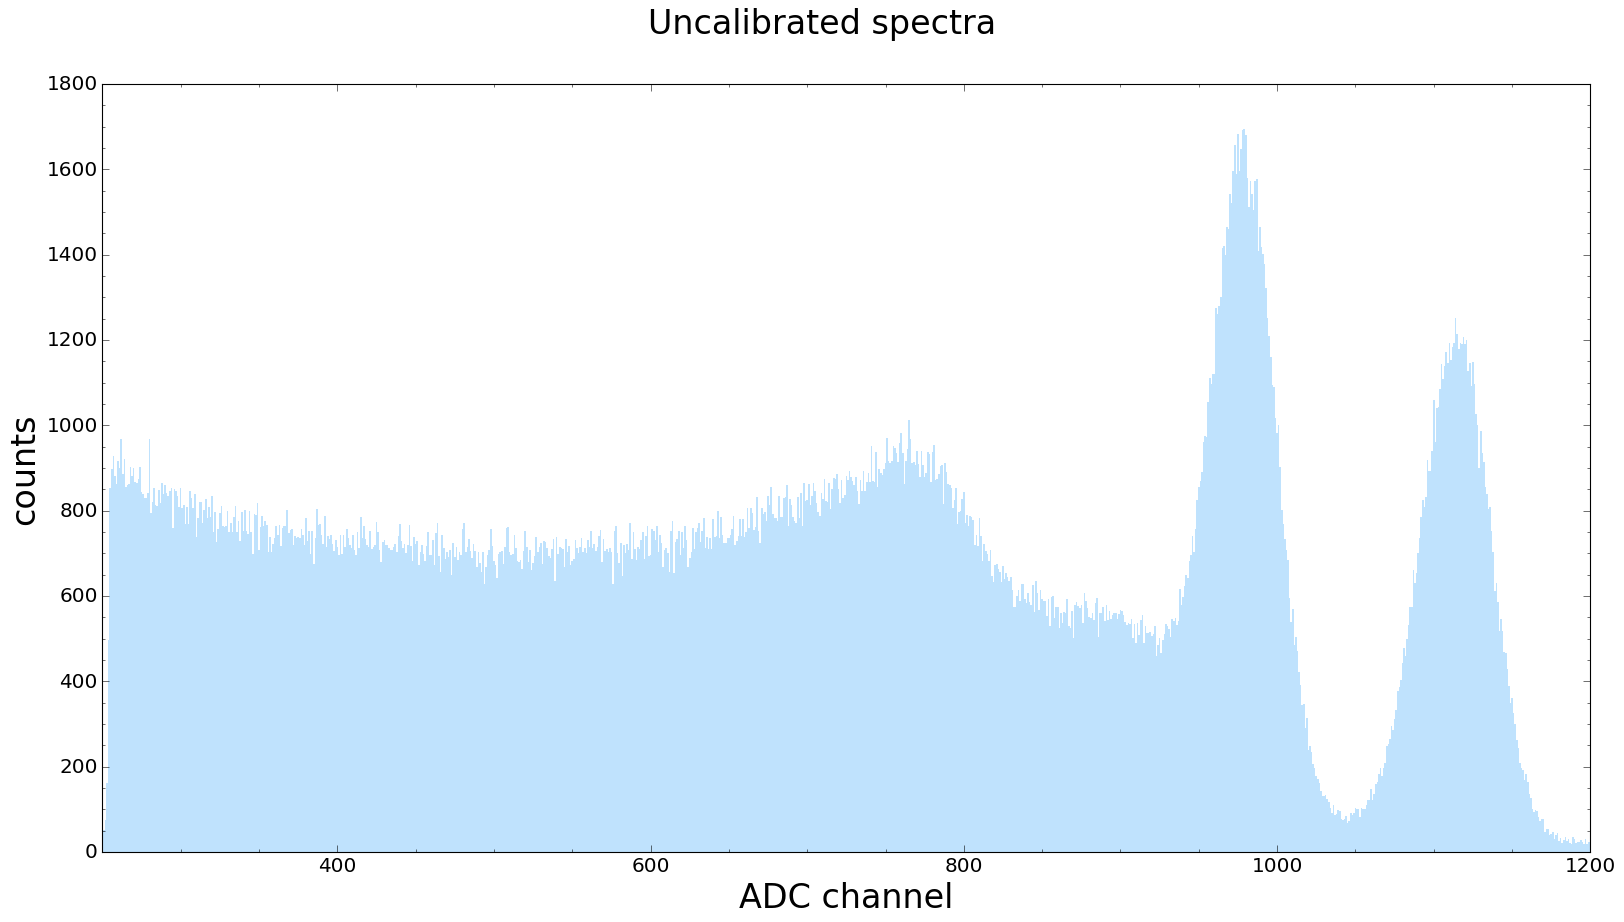

In [7]:
fig, ax = plt.subplots(); fig.patch.set_facecolor('xkcd:white')
plt.rcParams['figure.figsize'] = [24, 12]
plt.suptitle("Uncalibrated spectra", fontsize = 30)
ax.tick_params(which = 'both', axis = 'both', direction='in', right = True, top = True, length = 6)
ax.minorticks_on()
ax.tick_params(which = 'minor', axis = 'both', direction='in', right = True, top = True, length = 3)
ax.tick_params(axis = 'both', labelsize = 18)
ax.set_xlabel("ADC channel", fontsize = 30)
ax.set_ylabel("counts", fontsize = 30)

ax.bar(xbins[xMin:xMax:], bin_content[xMin:xMax:], width = xbins[1] - xbins[0], align = "center", label = "60Co_CLYC_ML", 
        color = "#95d0fc", linewidth = 0., alpha = 0.6)
ax.set_xlim(xMin, xMax)

In [8]:
'''
    defintion of relevant functions for calibration
'''

def gauss(x, A, x0, sigma, a, b):
    return A * np.exp( -(x-x0)**2 / (2*sigma**2)) + a + b*x

def linear(x, a, b):
    return a + b * x
    
def inv_linear(y, a, b): # invert the linear for y = a + b * x
    return (y - a) / b

In [9]:
sol = so.curve_fit(gauss, xbins[xMinfit1:xMaxfit1:], bin_content[xMinfit1:xMaxfit1:], sigma = np.sqrt(bin_content[xMinfit1:xMaxfit1:]), p0 = p01, absolute_sigma = True, maxfev = 300)
coef1, cov1 = sol
A1, x01, sigma1, a1, b1 = coef1; uA1, ux01, usigma1, ua1, ub1 = np.sqrt(np.diag(cov1))

sol = so.curve_fit(gauss, xbins[xMinfit2:xMaxfit2:], bin_content[xMinfit2:xMaxfit2:], sigma = np.sqrt(bin_content[xMinfit2:xMaxfit2:]), p0 = p02, absolute_sigma = True, maxfev = 300)
coef2, cov2 = sol
A2, x02, sigma2, a2, b2 = coef2; uA2, ux02, usigma2, ua2, ub2 = np.sqrt(np.diag(cov2))

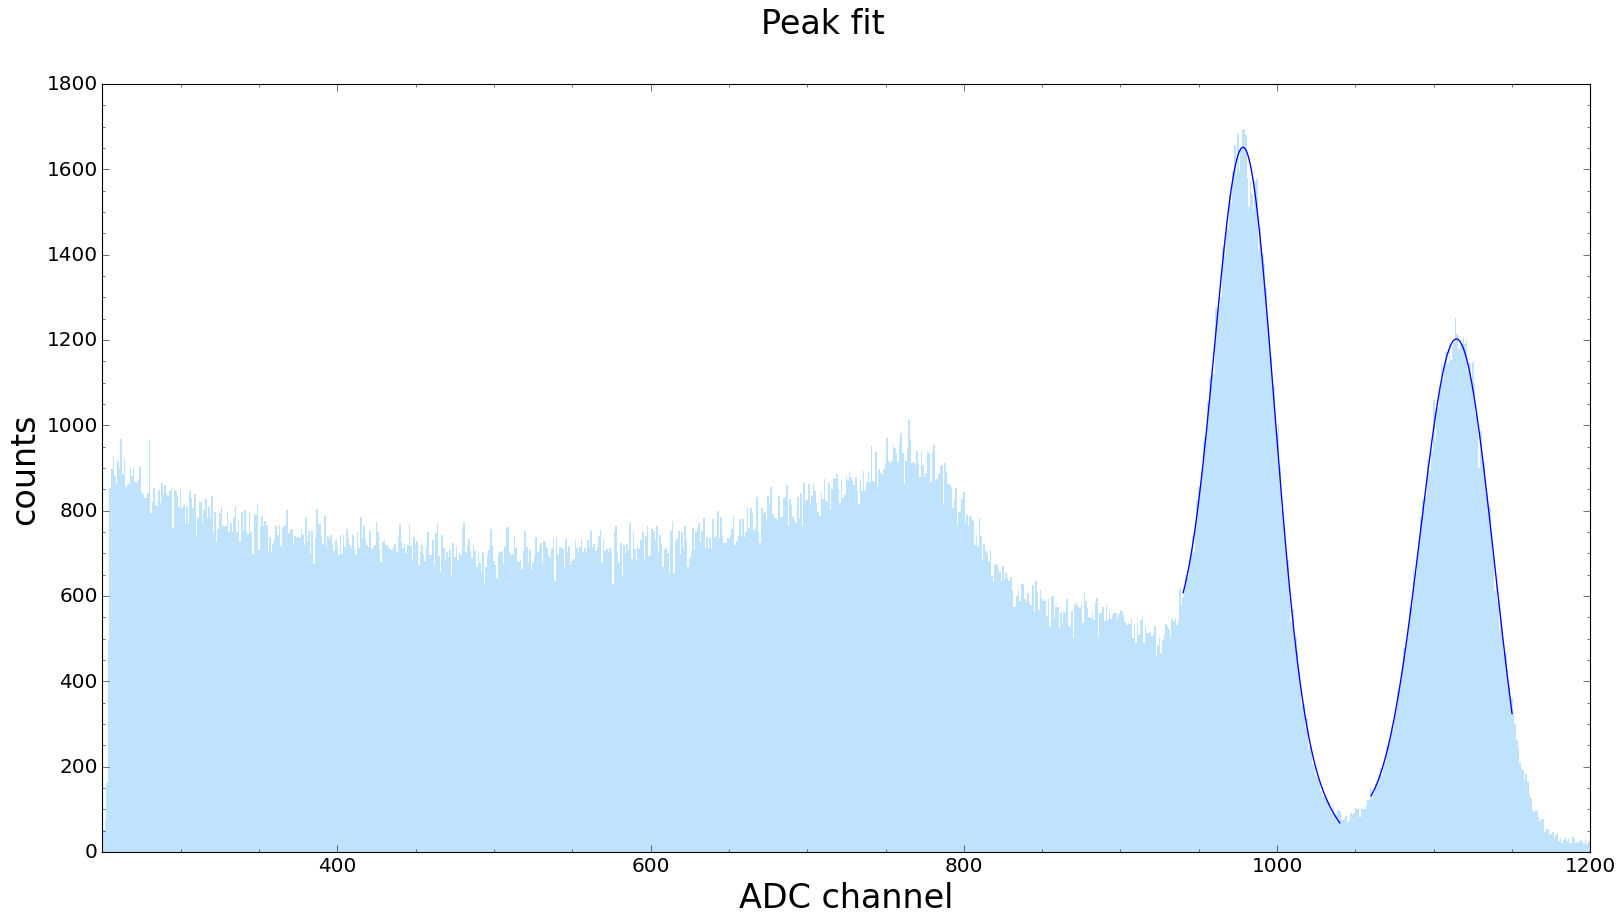

In [10]:
fig, ax = plt.subplots(); fig.patch.set_facecolor('xkcd:white')
plt.rcParams['figure.figsize'] = [24, 12]
plt.suptitle("Peak fit", fontsize = 30)
ax.tick_params(which = 'both', axis = 'both', direction='in', right = True, top = True, length = 6)
ax.minorticks_on()
ax.tick_params(which = 'minor', axis = 'both', direction='in', right = True, top = True, length = 3)
ax.tick_params(axis = 'both', labelsize = 18)
ax.set_xlabel("ADC channel", fontsize = 30)
ax.set_ylabel("counts", fontsize = 30)

ax.bar(xbins[xMin:xMax:], bin_content[xMin:xMax:], width = xbins[1] - xbins[0], align = "center", label = "60Co_CLYC_ML", 
        color = "#95d0fc", linewidth = 0., alpha = 0.6)
ax.set_xlim(xMin, xMax)

xaux1 = np.linspace(xMinfit1, xMaxfit1, 1000)
ax.plot(xaux1, gauss(xaux1, *coef1), color = 'blue', linewidth = 1.2, linestyle = 'solid', label = '$1173 keV peak$')

xaux2 = np.linspace(xMinfit2, xMaxfit2, 1000)
ax.plot(xaux2, gauss(xaux2, *coef2), color = 'blue', linewidth = 1.2, linestyle = 'solid', label = '$1332 keV peak$')

resolutions = 100 * 2.35 * np.array([np.abs(sigma1) / x01, np.abs(sigma2) / x02], "float")

In [11]:
xp = [1172, 1332]
xs = [x01, x02]
uxs = [ux01, ux02]
sol = so.curve_fit(linear, xp, xs, sigma = uxs, absolute_sigma = True)

xMax_E = int(inv_linear(xMax, *sol[0]))
xMin_E = int(inv_linear(xMin, *sol[0]))
energy = inv_linear(xbins, *sol[0])

Text(1213.7775357216847, 1240.8915435642575, '$ R = 4.98\\ {\\rm per\\, cent}$')

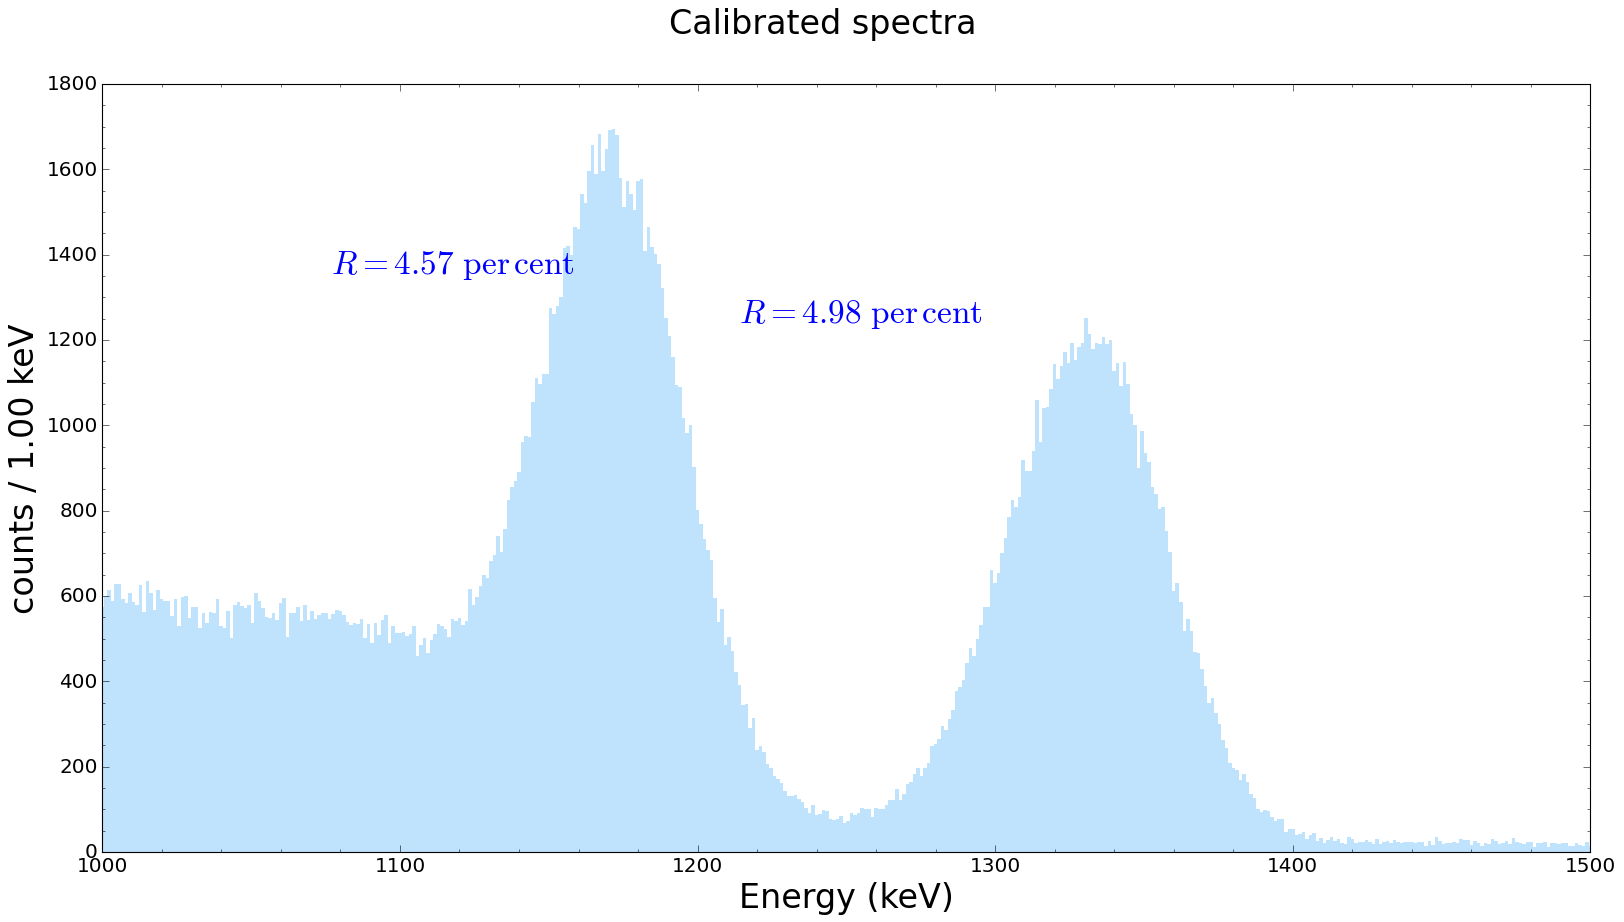

In [12]:
fig, ax = plt.subplots(); fig.patch.set_facecolor('xkcd:white')
plt.rcParams['figure.figsize'] = [24, 12]
plt.suptitle("Calibrated spectra", fontsize = 30)
ax.tick_params(which = 'both', axis = 'both', direction='in', right = True, top = True, length = 6)
ax.minorticks_on()
ax.tick_params(which = 'minor', axis = 'both', direction='in', right = True, top = True, length = 3)
ax.tick_params(axis = 'both', labelsize = 18)
ax.set_xlabel("Energy (keV)", fontsize = 30)
ax.set_ylabel("counts / %.2f keV" % (xbins[1] - xbins[0]), fontsize = 30)

ax.bar(energy[xMin_E:xMax_E:], bin_content[xMin_E:xMax_E:], width = energy[1] - energy[0], align = "center", label = "60Co_CLYC_ML", 
        color = "#95d0fc", linewidth = 0., alpha = 0.6)
ax.set_xlim(1000, 1500)

ax.text(xp[0] - 5 * sigma1, A1, "$ R = %1.2f\ {\\rm per\, cent}$" % resolutions[0], color = 'blue', fontsize = 30)
ax.text(xp[1] - 5 * np.abs(sigma2), A2, "$ R = %1.2f\ {\\rm per\, cent}$" % resolutions[1], color = 'blue', fontsize = 30)

In [13]:
try:
    os.makedirs(analysis_dir + date)
except FileExistsError:
    # directory already exists
    pass

with open(analysis_dir + date + fileName + "_cal.csv", 'w') as f:
    f.write(",1173 peak,1332 peak\n")
    f.write("Resolution (per cent), %.3f, %.3f" % (resolutions[0], resolutions[1]))
f.close()